In [31]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace
from importlib import reload
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import sys
#sys.path.append("/home/kim2712/Desktop/research/conformal_tree/")
sys.path.append("/home/kim2712/Desktop/research/generative_quantile/generative_qunatile/brenier/")
sys.path.append("/home/kim2712/Desktop/research/generative_quantile/generative_qunatile")

In [33]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)

import torch
torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
import argparse
import numpy as np
import scipy

#our libs
import matplotlib.pyplot as plt
import seaborn as sns
#import utils
#from utils import truncated_normal
#from gen_data import *
#from torchvision import datasets, transforms, utils
from models import ConditionalConvexQuantile,dual_JK


In [34]:
from _utils.breiner_util import plot2d, histogram, plotaxis
from _data.gaussian_conjugate import forward_sampler, posterior_sampler

In [35]:
class args:
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    use_f = False
    
    gauss=True#False#True #False
    batch_size = 128 
    epoch = 150 
    n_iter= 100
    
    optimizer='adam'
    lr=0.01#05
    beta1 = 0.9 
    beta2=0.999
    nesterov=False
    iters=1000
    mean=0
    std=1    


    eps=0
    
    n_sample = 2

In [36]:
print("Input arguments:")
for key, val in vars(args).items():
    print("{:16} {}".format(key, val))

Input arguments:
__module__       __main__
device           cuda
use_f            False
gauss            True
batch_size       128
epoch            150
n_iter           100
optimizer        adam
lr               0.01
beta1            0.9
beta2            0.999
nesterov         False
iters            1000
mean             0
std              1
eps              0
n_sample         2
__dict__         <attribute '__dict__' of 'args' objects>
__weakref__      <attribute '__weakref__' of 'args' objects>
__doc__          None


In [37]:
HPARAM = {"nu":1, "sigma0_sq":1, "mu0":0,"kappa":2}
#ds = Synthetic(args, n=args.n)
#loader = data.DataLoader(ds, batch_size=args.batch_size, shuffle=True, drop_last=True)

In [38]:
def unif(size, eps=1E-7, device ="cuda"):
    return torch.clamp(torch.rand(size).to(device), min=eps, max=1-eps)

np_random = np.random.RandomState(1234)

def train(net, HPARAM, args):

    #eg = Rings() # EightGaussian()
    gauss = torch.distributions.normal.Normal(torch.tensor([0.]).to(args.device), 
                                              torch.tensor([1.]).to(args.device))
    for epoch in range(1, args.epoch+1):
        optimizer = optim.Adam(net.parameters(), lr=args.lr*(0.99**2), betas=(args.beta1, args.beta2))
        running_loss = 0.0
        for idx in range(args.n_iter):
        #for idx, (Y, label) in enumerate(loader):
            Y, label = forward_sampler(n = args.n_sample, 
                                batch_size=args.batch_size,
                                device=args.device,
                                h_param=HPARAM,
                                as_torch = True,
                                np_random = np_random)
            u = unif(size=(args.batch_size, args.n_sample), 
                     device=args.device)
            if args.gauss:
                u = gauss.icdf(u)
            optimizer.zero_grad()
            X,_ = net.f(label.unsqueeze(1))
            alpha, beta= net(u)
            loss = dual_JK(U=u, Y_hat=(alpha, beta), Y=Y, X=X, eps=args.eps, efficient=True)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if epoch % 10 == 0:
            print('%.5f' %
                (running_loss))#/(idx+1)))
            test(net, args, HPARAM)
            net.train()

    
def test(net, args, HPARAM, n_test = 500):
    theta, sigma_sq = posterior_sampler(X = torch.tensor([2.2,2.2]), batch_size=100)
    
    net.eval()
    gauss = torch.distributions.normal.Normal(torch.tensor([0.]).to(args.device), 
                                          torch.tensor([1.]).to(args.device))
    U = unif(size=(n_test, 2), device = args.device)
    if args.gauss:
        U = gauss.icdf(U)
    X = torch.ones((n_test,args.n_sample),
                          device=args.device)*2.2 #.long()
    #print(X)
    Y_hat,_ = net.grad(U, X.unsqueeze(1), onehot=False)#= net.forward(U, grad=True).sum()
    #Y_hat = net.grad(U)
    #print("max and min points generated: " + str(Y_hat.max()) + " " + str(Y_hat.min()))
    #plot(Y_hat, X ,HPARAM)
    Y_hat = Y_hat.detach().cpu()
    
    fig,axis = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

    ax=axis[0]
    sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=False) #, cmap="Blues"
    sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=True) #, cmap="Blues"

    ax=axis[1]
    sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=False) #, cmap="Blues"
    sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=True) #, cmap="Blues"

    fig.tight_layout()
    plt.show()

(-5.0, 5.0)

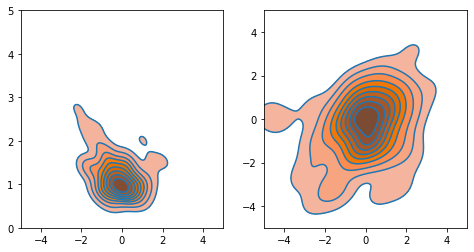

In [141]:
HPARAM = {"nu":25, "sigma0_sq":1, "mu0":0,"kappa":2}

Y,X= forward_sampler(n = 2, 
                                batch_size=100,
                                device=args.device,
                                h_param=HPARAM,
                                as_torch = False,
                                np_random = np_random)

fig,axis = plt.subplots(1,2, figsize=(8,4))#, sharex=True, sharey=True)

M=5

ax=axis[0]
sns.kdeplot(x=Y[:,0], y=Y[:,1], ax=ax, fill=False) #, cmap="Blues"
sns.kdeplot(x=Y[:,0], y=Y[:,1], ax=ax, fill=True) #, cmap="Blues"
ax.set_xlim(-M,M)
ax.set_ylim(0,M)


ax=axis[1]
sns.kdeplot(x=X[:,0], y=X[:,1], ax=ax, fill=False) #, cmap="Blues"
sns.kdeplot(x=X[:,0], y=X[:,1], ax=ax, fill=True) #, cmap="Blues"


ax.set_xlim(-M,M)
ax.set_ylim(-M,M)

In [77]:
X.shape

(10000, 2)

(-50.0, 50.0)

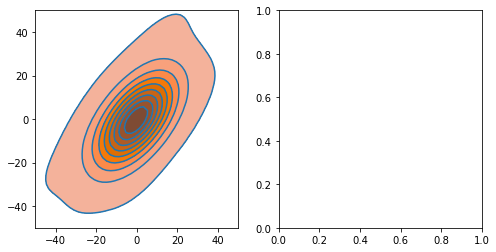

In [20]:
X.mean()

4.456016653518645

In [34]:
net = ConditionalConvexQuantile(xdim=args.n_sample,
                                ydim=2, 
                                a_hid=512,
                                a_layers=3,
                                b_hid=512,
                                b_layers=3, use_f=args.use_f)

net.to(args.device)
0

0

In [25]:
net.train()
train(net, HPARAM, args)

3105357.26058
> /home/kim2712/Desktop/research/generative_quantile/generative_qunatile/brenier/models.py(418)grad()
    416             set_trace()
    417             #phi += (torch.bmm(self.beta(u).unsqueeze(1), x.unsqueeze(-1)).squeeze(-1)).sum()
--> 418             phi += (self.beta(u) * x).sum(1).view(-1)
    419         phi = phi.sum()
    420         d_phi = torch.autograd.grad(phi, u, create_graph=True)[0]

ipdb> self.beta(u).shape
torch.Size([500, 2])
ipdb> print(x.shape)
torch.Size([500, 2])
ipdb> exit


BdbQuit: 

In [13]:
n_test = 500
theta, sigma_sq = posterior_sampler(X = torch.tensor([2.2,2.2]), 
                                                batch_size=args.batch_size,
                                                as_torch =False,
                                                np_random =np_random )
net.eval()
gauss = torch.distributions.normal.Normal(torch.tensor([0.]).to(args.device), 
                                          torch.tensor([1.]).to(args.device))
U = unif(size=(n_test, 2), device = args.device)
if args.gauss:
    U = gauss.icdf(U)
X = torch.ones((n_test,args.n_sample),
                      device=args.device)*2.2 #.long()
#print(X)
Y_hat,_ = net.grad(U, X.unsqueeze(1), onehot=False)#= net.forward(U, grad=True).sum()
#Y_hat = net.grad(U)
print("max and min points generated: " + str(Y_hat.max()) + " " + str(Y_hat.min()))
#plot(Y_hat, X ,HPARAM)
Y_hat = Y_hat.detach().cpu()

max and min points generated: tensor(12857.8965, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-174.9476, device='cuda:0', grad_fn=<MinBackward1>)


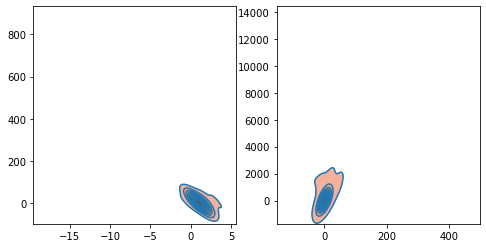

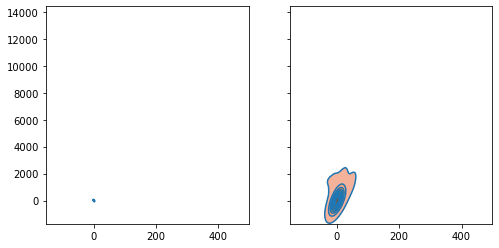

In [14]:
import seaborn as sns

fig,axis = plt.subplots(1,2, figsize=(8,4))#, sharex=True, sharey=True)

ax=axis[0]
sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=False) #, cmap="Blues"
sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=True) #, cmap="Blues"

ax=axis[1]
sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=False) #, cmap="Blues"
sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=True) #, cmap="Blues"

plt.show()

import seaborn as sns

fig,axis = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

ax=axis[0]
sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=False) #, cmap="Blues"
sns.kdeplot(x=theta, y=sigma_sq, ax=ax, fill=True) #, cmap="Blues"

ax=axis[1]
sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=False) #, cmap="Blues"
sns.kdeplot(x=Y_hat[:,0], y=Y_hat[:,1], ax=ax, fill=True) #, cmap="Blues"

plt.show()

In [ ]:
import pathlib
path = "./trained_nets"
pathlib.Path(path).mkdir(parents=True, exist_ok=True)
torch.save(net.state_dict(),  path+F"/gaussian_seed_all_x.net")